# LFM-2b Lyrics Data Analyses and Cleaning

In [1]:
import json
import langdetect
import re
import pickle
import math
from os.path import join
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
from collections import Counter
from scipy.stats import rankdata
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from scipy.stats import gaussian_kde

from sanitizer import sanitize_lyric
from analyzer import check_patterns, extract_annotations
from feature_extraction import extract_and_add_features

In [2]:
# FEATURES_PATH = "/mnt/e/Uni/Research/lfm2b-data/5Genres_SubSet.csv"
FULL_DATASET_PATH = "/mnt/e/Uni/Research/lfm2b-data/lyrics_distinct_all_features_non_null_lfm_playcount-2021-12-03.json"
FIGURE_PATH = "./results/"

In [3]:
pd.set_option("display.max_rows", None)

## Read lyrics

In [4]:
full_lyrics = []
with open(FULL_DATASET_PATH, "r") as fh:
    for line in fh:
        current_song = json.loads(line)
        full_lyrics.append(current_song)

df = pd.json_normalize(full_lyrics)

In [5]:
for col in df.columns:
    display(col)

'popularity'

'lfm_playcount'

'genre'

'genres_all'

'sanitized_lyrics'

'_id.artist'

'_id.track'

'release.$date'

'features.compression_ratio'

'features.entropy'

'features.uncommon_words_ratio'

'features.readability.flesch_kincaid_grade'

'features.readability.flesch_reading_ease'

'features.readability.smog'

'features.readability.automated_readability_index'

'features.readability.coleman_liau_index'

'features.readability.dale_chall_readability_score'

'features.readability.difficult_words'

'features.readability.linsear_write_formula'

'features.readability.gunning_fog'

'features.readability.fernandez_huerta'

'features.readability.szigriszt_pazos'

'features.readability.gutierrez_polini'

'features.readability.crawford'

'features.lexical.token_count'

'features.lexical.character_count'

'features.lexical.repeated_token_ratio'

'features.lexical.unique_tokens_per_line'

'features.lexical.average_token_length'

'features.lexical.average_tokens_per_line'

'features.lexical.line_count'

'features.lexical.unique_line_count'

'features.lexical.blank_line_count'

'features.lexical.blank_line_ratio'

'features.lexical.repeated_line_ratio'

'features.lexical.exclamation_mark_count'

'features.lexical.question_mark_count'

'features.lexical.digit_count'

'features.lexical.colon_count'

'features.lexical.semicolon_count'

'features.lexical.quote_count'

'features.lexical.comma_count'

'features.lexical.dot_count'

'features.lexical.hyphen_count'

'features.lexical.parens_count'

'features.lexical.punctuation_count'

'features.lexical.digit_ratio'

'features.lexical.punctuation_ratio'

'features.lexical.stop_word_count'

'features.lexical.stop_word_ratio'

'features.lexical.stop_words_per_line'

'features.lexical.unique_bigram_ratio'

'features.lexical.unique_trigram_ratio'

'features.lexical.hapax_legomenon_ratio'

'features.lexical.dis_legomenon_ratio'

'features.lexical.tris_legomenon_ratio'

'features.lexical.mtld'

'features.lexical.herdan'

'features.lexical.summer'

'features.lexical.dugast'

'features.lexical.maas'

'features.lexical.pronoun_frequency'

'features.lexical.past_tense_ratio'

'features.structure.chorus_repetitions'

'features.structure.title_occurrences'

'features.structure.number_of_sections'

'features.structure.number_of_verses'

'features.structure.starts_with_chorus'

'features.structure.ratio_verses_sections'

'features.structure.ratio_chorus_sections'

'features.structure.ends_with_two_chorus_repetitions'

'features.structure.pattern_verse_chorus_alternating'

'features.structure.pattern_two_verses_at_least_one_chorus'

'features.structure.pattern_two_choruses_at_least_one_verse'

'features.rhyme.num_couplets'

'features.rhyme.num_clerihews'

'features.rhyme.num_alternating'

'features.rhyme.num_nested'

'features.rhyme.alliterations_len_2'

'features.rhyme.alliterations_len_3'

'features.rhyme.alliterations_len_4_plus'

'features.rhyme.rhyme_percent'

'features.rhyme.unique_rhyme_words'

'affective.AFINN.PositiveScore'

'affective.AFINN.NegativeScore'

'affective.BingLiu.positive'

'affective.BingLiu.negative'

'affective.MPQA.positive'

'affective.MPQA.negative'

'affective.NRCAffectIntensity.Anger'

'affective.NRCAffectIntensity.Anticipation'

'affective.NRCAffectIntensity.Disgust'

'affective.NRCAffectIntensity.Fear'

'affective.NRCAffectIntensity.Joy'

'affective.NRCAffectIntensity.Negative'

'affective.NRCAffectIntensity.Positive'

'affective.NRCAffectIntensity.Sadness'

'affective.NRCAffectIntensity.Surprise'

'affective.NRCAffectIntensity.Trust'

'affective.NRCEmotionWordlevel.Anger'

'affective.NRCEmotionWordlevel.Anticipation'

'affective.NRCEmotionWordlevel.Disgust'

'affective.NRCEmotionWordlevel.Fear'

'affective.NRCEmotionWordlevel.Joy'

'affective.NRCEmotionWordlevel.Negative'

'affective.NRCEmotionWordlevel.Positive'

'affective.NRCEmotionWordlevel.Sadness'

'affective.NRCEmotionWordlevel.Surprise'

'affective.NRCEmotionWordlevel.Trust'

'affective.NRCExpandedEmotion.Anger'

'affective.NRCExpandedEmotion.Anticipation'

'affective.NRCExpandedEmotion.Disgust'

'affective.NRCExpandedEmotion.Fear'

'affective.NRCExpandedEmotion.Joy'

'affective.NRCExpandedEmotion.Negative'

'affective.NRCExpandedEmotion.Positive'

'affective.NRCExpandedEmotion.Sadness'

'affective.NRCExpandedEmotion.Surprise'

'affective.NRCExpandedEmotion.Trust'

'affective.NRCHashtagEmotion.Anger'

'affective.NRCHashtagEmotion.Anticipation'

'affective.NRCHashtagEmotion.Disgust'

'affective.NRCHashtagEmotion.Fear'

'affective.NRCHashtagEmotion.Joy'

'affective.NRCHashtagEmotion.Negative'

'affective.NRCHashtagEmotion.Positive'

'affective.NRCHashtagEmotion.Sadness'

'affective.NRCHashtagEmotion.Surprise'

'affective.NRCHashtagEmotion.Trust'

'affective.NRCHashtagSentiment.PositiveScore'

'affective.NRCHashtagSentiment.NegativeScore'

'affective.Sentiment140.PositiveScore'

'affective.Sentiment140.NegativeScore'

'affective.SentiWordNet.PositiveScore'

'affective.SentiWordNet.NegativeScore'

'affective.Negation.count'

'affective.LIWC.>six_letter_words'

'affective.LIWC.Apostro'

'affective.LIWC.Colon'

'affective.LIWC.Comma'

'affective.LIWC.Dash'

'affective.LIWC.Exclam'

'affective.LIWC.OtherP'

'affective.LIWC.Parenth'

'affective.LIWC.Period'

'affective.LIWC.QMark'

'affective.LIWC.Quote'

'affective.LIWC.SemiC'

'affective.LIWC.achieve'

'affective.LIWC.adverb'

'affective.LIWC.affect'

'affective.LIWC.anger'

'affective.LIWC.anx'

'affective.LIWC.article'

'affective.LIWC.assent'

'affective.LIWC.auxverb'

'affective.LIWC.avg_sentence_length'

'affective.LIWC.bio'

'affective.LIWC.body'

'affective.LIWC.cause'

'affective.LIWC.certain'

'affective.LIWC.cogmech'

'affective.LIWC.conj'

'affective.LIWC.death'

'affective.LIWC.dictionary_words'

'affective.LIWC.discrep'

'affective.LIWC.excl'

'affective.LIWC.family'

'affective.LIWC.feel'

'affective.LIWC.filler'

'affective.LIWC.friend'

'affective.LIWC.funct'

'affective.LIWC.future'

'affective.LIWC.health'

'affective.LIWC.hear'

'affective.LIWC.home'

'affective.LIWC.humans'

'affective.LIWC.i'

'affective.LIWC.incl'

'affective.LIWC.ingest'

'affective.LIWC.inhib'

'affective.LIWC.insight'

'affective.LIWC.ipron'

'affective.LIWC.leisure'

'affective.LIWC.money'

'affective.LIWC.motion'

'affective.LIWC.negate'

'affective.LIWC.negemo'

'affective.LIWC.nonfl'

'affective.LIWC.number'

'affective.LIWC.numerals'

'affective.LIWC.past'

'affective.LIWC.percept'

'affective.LIWC.posemo'

'affective.LIWC.ppron'

'affective.LIWC.preps'

'affective.LIWC.present'

'affective.LIWC.pronoun'

'affective.LIWC.quant'

'affective.LIWC.relativ'

'affective.LIWC.relig'

'affective.LIWC.sad'

'affective.LIWC.see'

'affective.LIWC.sexual'

'affective.LIWC.shehe'

'affective.LIWC.social'

'affective.LIWC.space'

'affective.LIWC.swear'

'affective.LIWC.tentat'

'affective.LIWC.they'

'affective.LIWC.time'

'affective.LIWC.total_word_count'

'affective.LIWC.verb'

'affective.LIWC.we'

'affective.LIWC.work'

'affective.LIWC.you'

'affective.LabMT.happiness'

'release.$date.$numberLong'

In [6]:
df['release_dt'] = df['release.$date'].apply(pd.to_datetime)
df['release_dt'].isna().sum()
df = df[df['release_dt'].notnull()]

features = [
    'features.compression_ratio', 
    'features.entropy', 
    'features.uncommon_words_ratio', 
    'features.readability.flesch_kincaid_grade', 
    'features.readability.flesch_reading_ease', 
    'features.readability.smog', 
    'features.readability.automated_readability_index', 
    'features.readability.coleman_liau_index', 
    'features.readability.dale_chall_readability_score', 
    'features.readability.difficult_words', 
    'features.readability.linsear_write_formula', 
    'features.readability.gunning_fog', 
    'features.readability.fernandez_huerta', 
    'features.readability.szigriszt_pazos', 
    'features.readability.gutierrez_polini', 
    'features.readability.crawford', 
    'features.lexical.token_count', 
    'features.lexical.character_count', 
    'features.lexical.repeated_token_ratio', 
    'features.lexical.unique_tokens_per_line', 
    'features.lexical.average_token_length', 
    'features.lexical.average_tokens_per_line', 
    'features.lexical.line_count', 
    'features.lexical.unique_line_count', 
    'features.lexical.blank_line_count', 
    'features.lexical.blank_line_ratio', 
    'features.lexical.repeated_line_ratio', 
    'features.lexical.exclamation_mark_count', 
    'features.lexical.question_mark_count', 
    'features.lexical.digit_count', 
    'features.lexical.colon_count', 
    'features.lexical.semicolon_count', 
    'features.lexical.quote_count', 
    'features.lexical.comma_count',
    'features.lexical.dot_count', 
    'features.lexical.hyphen_count', 
    'features.lexical.parens_count', 
    'features.lexical.punctuation_count', 
    'features.lexical.digit_ratio', 
    'features.lexical.punctuation_ratio', 
    'features.lexical.stop_word_count', 
    'features.lexical.stop_word_ratio', 
    'features.lexical.stop_words_per_line', 
    'features.lexical.unique_bigram_ratio', 
    'features.lexical.unique_trigram_ratio', 
    'features.lexical.hapax_legomenon_ratio', 
    'features.lexical.dis_legomenon_ratio', 
    'features.lexical.tris_legomenon_ratio', 
    'features.lexical.mtld', 
    'features.lexical.herdan', 
    'features.lexical.summer', 
    'features.lexical.dugast', 
    'features.lexical.maas', 
    'features.lexical.pronoun_frequency', 
    'features.lexical.past_tense_ratio', 
    'features.structure.chorus_repetitions', 
    'features.structure.title_occurrences', 
    'features.structure.number_of_sections', 
    'features.structure.number_of_verses', 
    'features.structure.starts_with_chorus', 
    'features.structure.ratio_verses_sections', 
    'features.structure.ratio_chorus_sections', 
    'features.structure.ends_with_two_chorus_repetitions', 
    'features.structure.pattern_verse_chorus_alternating', 
    'features.structure.pattern_two_verses_at_least_one_chorus', 
    'features.structure.pattern_two_choruses_at_least_one_verse', 
    'features.rhyme.num_couplets', 
    'features.rhyme.num_clerihews', 
    'features.rhyme.num_alternating', 
    'features.rhyme.num_nested', 
    'features.rhyme.alliterations_len_2', 
    'features.rhyme.alliterations_len_3', 
    'features.rhyme.alliterations_len_4_plus', 
    'features.rhyme.rhyme_percent', 
    'features.rhyme.unique_rhyme_words', 
    'affective.LIWC.anger', 
    'affective.LIWC.anx', 
    'affective.LIWC.negemo', 
    'affective.LIWC.posemo', 
    'affective.LIWC.sad',
]

genres = ["pop", "rock", "rap", "country", "r-b"]

## Clean Dataset

In [7]:
columns = ["genre", "release_dt"] + features
df = df[columns]
display(df.shape[0])
df_cleaned = df.dropna()
display(df_cleaned.shape[0])

573829

353320

## Feature Importance

In [8]:
importance_results = []

for genre in genres:
    # Get data points for this genres.
    data = df_cleaned[(df_cleaned["genre"] == genre) & (df_cleaned["release_dt"].dt.year >= 1980)]

    X = data[features]
    y = data["release_dt"].dt.year.to_numpy()

    # Train the decision tree model and obtain feature importance.
    dt = DecisionTreeClassifier()
    dt.fit(X, y)

    dt_ranks = rankdata(-1 * dt.feature_importances_, method="min")

    # Determine feature importance via permutation_importance.
    perm_imp = permutation_importance(dt, X, y, n_repeats=10, random_state=42)
    perm_ranks = rankdata(-1 * perm_imp.importances_mean, method="min")

    # Determine feature ranking via recursive feature elimination.
    dt2 = DecisionTreeClassifier()
    rfe = RFE(dt2, n_features_to_select=1, step=1)
    rfe.fit(X, y)

    # Add results.
    importances = np.array([features, dt.feature_importances_, dt_ranks, perm_imp.importances_mean, perm_ranks, rfe.ranking_])
    importances_per_feature = np.transpose(importances)

    importance_results.append([genre, importances_per_feature])

In [9]:
for i in range(0, len(importance_results)):
    importance_results[i][1] = pd.DataFrame(importance_results[i][1], columns=["Feature", "DT Score", "DT Rank", "Permutation Score", "Permutation Rank", "RFE Rank"])

    display(importance_results[i][0])
    display(importance_results[i][1].sort_values(by="Permutation Rank", key=lambda col: col.astype(int)))

'pop'

,Feature,DT Score,DT Rank,Permutation Score,Permutation Rank,RFE Rank
56,features.structure.title_occurrences,0.011812732733479058,41,0.4698660511441086,1,51
26,features.lexical.repeated_line_ratio,0.023651977443827146,8,0.320661202086476,2,16
36,features.lexical.parens_count,0.00804589852466563,56,0.2822495047345559,3,58
55,features.structure.chorus_repetitions,0.006421801563040313,63,0.24825248541465986,4,65
1,features.entropy,0.01988078813681513,16,0.22126188182693882,5,9
74,features.rhyme.unique_rhyme_words,0.013860419817664234,37,0.208766652732593,6,43
53,features.lexical.pronoun_frequency,0.02584069921405926,1,0.1877455880481998,7,6
61,features.structure.ratio_chorus_sections,0.0062511510796467995,65,0.1875947365551335,8,54
39,features.lexical.punctuation_ratio,0.021026555308890523,15,0.1809172861271151,9,11
20,features.lexical.average_token_length,0.023311959893096902,9,0.16705348866796316,10,1


'rock'

,Feature,DT Score,DT Rank,Permutation Score,Permutation Rank,RFE Rank
56,features.structure.title_occurrences,0.009731052182656859,50,0.4978291589966717,1,52
58,features.structure.number_of_verses,0.004181229340789595,66,0.3129181309384355,2,66
41,features.lexical.stop_word_ratio,0.024512021854229068,6,0.2645023335378665,3,3
44,features.lexical.unique_trigram_ratio,0.016536362264864407,26,0.24568249009873372,4,9
40,features.lexical.stop_word_count,0.015288181074485874,28,0.23750766999497958,5,26
9,features.readability.difficult_words,0.01687078277150665,25,0.23060746360238746,6,29
26,features.lexical.repeated_line_ratio,0.0218459791066245,11,0.21598241014484665,7,17
39,features.lexical.punctuation_ratio,0.02160741993593886,12,0.18099235789591123,8,13
61,features.structure.ratio_chorus_sections,0.007759153759973825,57,0.17068388464327552,9,55
20,features.lexical.average_token_length,0.022279742150976226,10,0.16951897510273145,10,2


'rap'

,Feature,DT Score,DT Rank,Permutation Score,Permutation Rank,RFE Rank
61,features.structure.ratio_chorus_sections,0.010871747783384325,46,0.45727291788516505,1,49
58,features.structure.number_of_verses,0.006268554451123262,68,0.4069037818510875,2,62
60,features.structure.ratio_verses_sections,0.004606288518865299,69,0.3120485118686339,3,69
39,features.lexical.punctuation_ratio,0.020853252930183294,12,0.3101669664632464,4,4
26,features.lexical.repeated_line_ratio,0.021220616054045505,9,0.2283798845691206,5,10
43,features.lexical.unique_bigram_ratio,0.015617617614367538,25,0.21393778209386757,6,35
19,features.lexical.unique_tokens_per_line,0.0186633879019206,18,0.19779070152399664,7,18
35,features.lexical.hyphen_count,0.013296973128867068,37,0.17834953706258208,8,47
1,features.entropy,0.017987280985396693,21,0.16243420108809606,9,17
18,features.lexical.repeated_token_ratio,0.014006581787805557,32,0.15954622201132235,10,42


'country'

,Feature,DT Score,DT Rank,Permutation Score,Permutation Rank,RFE Rank
43,features.lexical.unique_bigram_ratio,0.020017152221949188,16,0.5124365686669351,1,11
56,features.structure.title_occurrences,0.017621506948973607,25,0.3109061619009263,2,43
24,features.lexical.blank_line_count,0.00892753228881106,52,0.27665726943213853,3,53
0,features.compression_ratio,0.020478587500378433,15,0.22367297623842125,4,18
44,features.lexical.unique_trigram_ratio,0.018260758549956933,24,0.21403141361256545,5,24
17,features.lexical.character_count,0.01865244476553589,18,0.21213854208618604,6,39
61,features.structure.ratio_chorus_sections,0.008379289056398351,56,0.207482883608538,7,46
60,features.structure.ratio_verses_sections,0.0068990834530476,59,0.1769391864679823,8,62
39,features.lexical.punctuation_ratio,0.021150330674343097,14,0.1396294804671768,9,9
22,features.lexical.line_count,0.014781939030803347,36,0.13524768425291983,10,29


'r-b'

,Feature,DT Score,DT Rank,Permutation Score,Permutation Rank,RFE Rank
36,features.lexical.parens_count,0.014354644628368296,35,0.47200869524998845,1,44
26,features.lexical.repeated_line_ratio,0.02721766069040513,1,0.4428564821238611,2,13
75,affective.LIWC.anger,0.017272406275678782,21,0.349345543684381,3,38
23,features.lexical.unique_line_count,0.018613765511075814,17,0.22109060635493272,4,30
60,features.structure.ratio_verses_sections,0.011366543654917191,46,0.20981915730077239,5,45
40,features.lexical.stop_word_count,0.01809211153331302,18,0.1945423430923639,6,34
78,affective.LIWC.posemo,0.025606304948667464,3,0.15878081494842974,7,7
19,features.lexical.unique_tokens_per_line,0.01950426368068741,15,0.15409555524721336,8,5
53,features.lexical.pronoun_frequency,0.024027681672306928,4,0.13912399981499468,9,1
20,features.lexical.average_token_length,0.021673580075493654,8,0.11984644558531059,10,17


Title Occurrences


,Genre,m,b
0,pop,0.076369,-148.853860
1,rock,0.048616,-94.762534
2,rap,0.057081,-111.274239
3,country,0.063328,-122.407981
4,r-b,-0.034537,75.226172


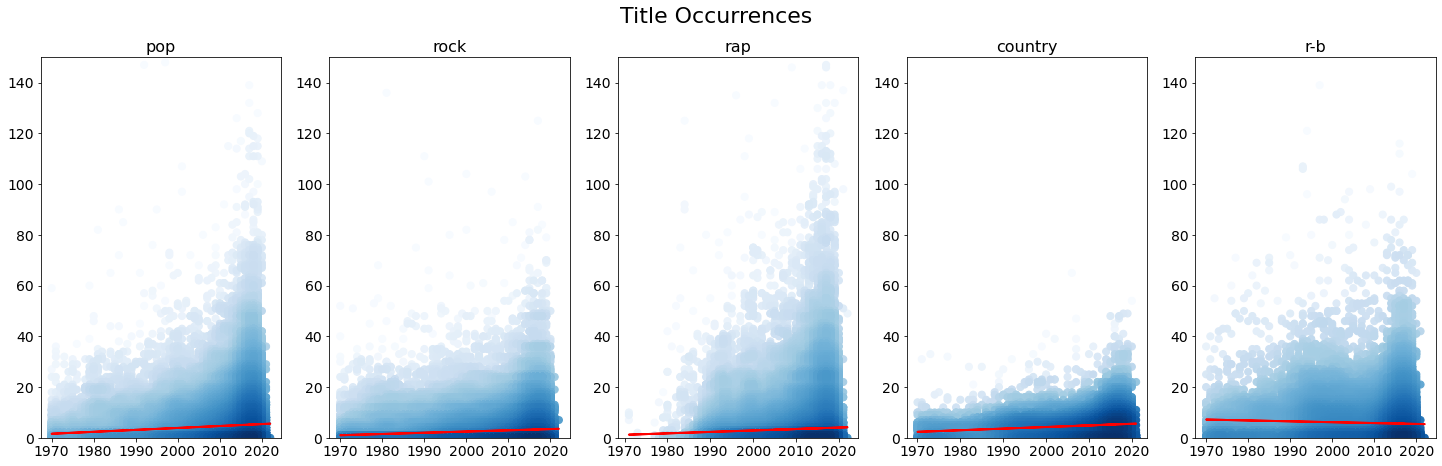

KeyboardInterrupt: 

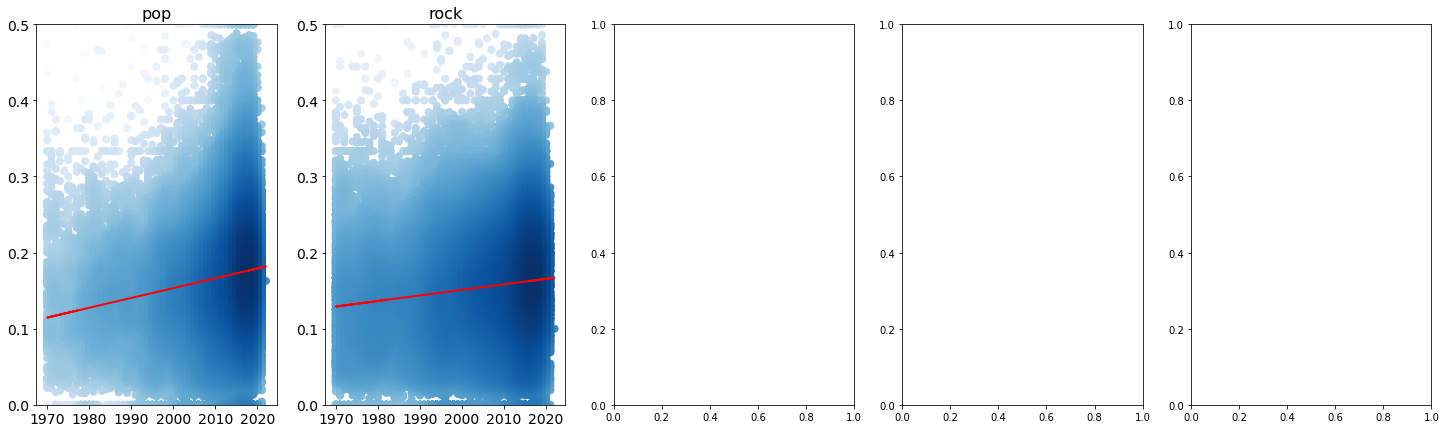

In [10]:
features_to_plot = [
    ("features.structure.title_occurrences", "Title Occurrences", 150.0),
    ("features.lexical.repeated_line_ratio", "Repeated Line Ratio", 0.5),
    ("affective.LIWC.posemo", "Positive Emotions", 50.0),
    ("features.structure.ratio_chorus_sections", "Ratio Chorus to Sections", 1.0),
    ("features.lexical.dis_legomenon_ratio", "Dis-legomenon Ratio", 1.0),
    ("features.lexical.pronoun_frequency", "Pronoun Frequency", 0.6),
    ("features.lexical.average_token_length", "Average Token Length", 8.0),
    ("features.lexical.line_count", "Line Count", 400.0),
    ("features.lexical.punctuation_ratio", "Punctuation Ratio", 0.3),
    ("features.lexical.unique_tokens_per_line", "Unique Tokens per Line", 150.0),
    ("features.lexical.past_tense_ratio", "Past Tense Ratio", 1.0),
    ("features.lexical.token_count", "Token Count", 5000.0),
]


for f in features_to_plot:
    feature = f[0]
    title = f[1]
    max_y = f[2]
    
    fig, axes = plt.subplots(ncols=len(genres), nrows=1, figsize=(25,7))
    fit_params = []
    
    for i, genre in enumerate(genres):
        # Get the data.
        X_plot = df_cleaned[df_cleaned["genre"] == genre].loc[:, "release_dt"].dt.year.to_numpy(dtype="float64")
        y_plot = df_cleaned[df_cleaned["genre"] == genre].loc[:, feature].to_numpy(dtype="float64")
        
        # Compute point density.
        xy = np.vstack([X_plot,y_plot])
        z = gaussian_kde(xy)(xy)
        
        # Compute linear regression line.
        m, b = np.polyfit(X_plot, y_plot, 1)
        
        # Sort data points by density value.
        sorting = z.argsort()
        X_plot, y_plot, z = X_plot[sorting], y_plot[sorting], z[sorting]
        
        # Scatter plot the feature values vs time.
        axes[i].scatter(x=X_plot, y=y_plot, c=z, s=50, cmap="Blues", norm=LogNorm())
        
        # Plot linear regression line.
        axes[i].plot(X_plot, m*X_plot + b, c="red", linewidth=2)
        
        # Set title.
        axes[i].set_title(genre, fontsize=16)
        
        # Set tick font size
        plt.setp(axes[i].get_xticklabels(), fontsize=14)
        plt.setp(axes[i].get_yticklabels(), fontsize=14)
        
        # Set max y value.
        axes[i].set_ylim(0, max_y)
        
        # Save linear git parameters.
        fit_params.append([genre, m, b])
        
        # df.pivot_table(index="Date", columns="Genre", values=feature, aggfunc=[np.mean, np.std]).plot(y="mean",yerr="std", subplots=True, sharex=True, sharey=True, legend=False, ecolor="grey", capsize=3, title=feature, figsize=(8,6))
        # lgd = plt.figlegend(loc="lower center", ncol=5,  bbox_to_anchor=(0.5, -0.03, 0, 0))
        # plt.savefig(FIGURE_PATH + f"evolution_{feature}.png", bbox_extra_artists=[lgd], bbox_inches='tight', pad_inches=1)
        # plt.show()
        
    fig.suptitle(title, fontsize=22)
    
    print(title)
    
    display(pd.DataFrame(fit_params, columns=["Genre", "m", "b"]))
    
    plt.savefig(FIGURE_PATH + f"evolution_{feature}.png")
    plt.show()
    
    
    